# 1. Some pre-installation and pre-loading

In [ ]:
# %%capture
# import torch
# major_version, minor_version = torch.cuda.get_device_capability()
# # Must install separately since Colab has torch 2.2.1, which breaks packages
# !pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# if major_version >= 8:
#     # Use this for new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
#     !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
# else:
#     # Use this for older GPUs (V100, Tesla T4, RTX 20xx)
#     !pip install --no-deps xformers trl peft accelerate bitsandbytes
# pass

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/Shareddrives/CS685Project/Project/

Mounted at /content/drive
/content/drive/Shareddrives/CS685Project/Project


In [4]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 4096 # 8192 | Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
] # More models at https://huggingface.co/unsloth

model, tokenizer= FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2b-it-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [5]:
# add lora to model
model = FastLanguageModel.get_peft_model(
    model,
    r = 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

# 2. Dataset Preparation

In [3]:
import json

# read the training data from json
with open('./data/training_data.json', 'r') as file:
    training_data = json.load(file)

# asins_small.json to be used for meta data matching
json_file_asins = './data/asins_small.json'
with open(json_file_asins, "r") as file:
    asin_dict = json.load(file)

In [4]:
from transformers import AutoTokenizer

prompt_template = "### Input:\n{}\n\n### Response:{}"

def token_length(text, tokenzier):
    input_ids = tokenizer(text, return_tensors="pt").to("cuda")
    return len(input_ids[0])

prompt_template_token_length = token_length(prompt_template, tokenizer)

In [6]:
from tqdm import tqdm

training_dict_wo_description = {"input": [], "output": []}
training_dict_w_description = {"input": [], "output": []}

for key in tqdm(training_data, total=len(training_data)):
    # print("synthesized intention: ", training_data[key]["intention"])
    # print("movie_sequence: ", training_data[key]["history"])
    synthesized_intention = training_data[key]["intention"]
    item_sequence = training_data[key]["history"]

    # beginning of the instruction:
    beginning_instruction = f"Below is the previous historical purchases and reviews of the user:\n```\n"

    # construct movie sequence text
    item_seq_text = ''
    for item in item_sequence[:-1]:
        title = asin_dict[item[5]][0]
        description = asin_dict[item[5]][1]
        rating = item[0]
        review = item[2]

        template = f"Item title: {title} \n Item description: {' '.join(description)} \n rating: {rating} \n review: {review}-------\n"
        item_seq_text += template

    # user's intention:
    user_intention_instruction = f"```\nAnd here is the user's intention: {synthesized_intention}\n"

    # ending of the instruction:
    ending_instruction_wo_description = f"Please infer the user's preference based on historical purchases and reviews along with the user's intention, and then recommend an item for this user."
    ending_instruction_w_description = f"Please infer the user's preference based on historical purchases and reviews along with the user's intention, and then recommend an item for this user and provide its description."

    # get the ground truth item
    output_wo_description = asin_dict[item_sequence[-1][5]][0] # targeted item's title
    output_w_description = f"Title: {asin_dict[item_sequence[-1][5]][0]} \n Description: {asin_dict[item_sequence[-1][5]][1]}"

    input_wo_description = beginning_instruction + item_seq_text + user_intention_instruction + ending_instruction_wo_description
    input_w_description = beginning_instruction + item_seq_text + user_intention_instruction + ending_instruction_w_description

    # appending to the list in training_dict with filtering on length
    if token_length(input_wo_description, tokenizer) <= max_seq_length - prompt_template_token_length:
        training_dict_wo_description["input"].append(input_wo_description)
        training_dict_wo_description["output"].append(output_wo_description)

    if token_length(input_w_description, tokenizer) <= max_seq_length - prompt_template_token_length:
        training_dict_w_description["input"].append(input_w_description)
        training_dict_w_description["output"].append(output_w_description)

    # WARNING: repeated data tokens. 
    # Potential solution: randomly choose from w w/o description.

# save to ./data
with open('./data/gemma_training_wo_description.json', 'w') as file:
    json.dump(training_dict_wo_description, file, indent=4)
with open('./data/gemma_training_w_description.json', 'w') as file:
    json.dump(training_dict_w_description, file, indent=4)

100%|██████████| 8241/8241 [00:48<00:00, 168.47it/s]


In [26]:
# read data
with open('./data/gemma_training_wo_description.json', 'r') as file:
    gemma_train_wo_description = json.load(file)
with open('./data/gemma_training_w_description.json', 'r') as file:
    gemma_train_w_description = json.load(file)

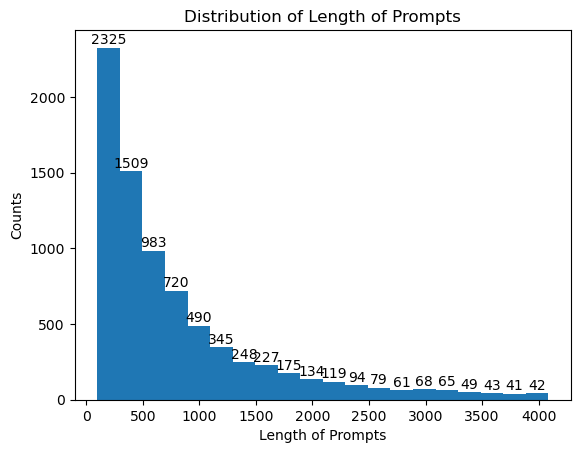

In [7]:
# Distribution of Length of Prompts in training dict
import matplotlib.pyplot as plt

# Assume 'length_of_prompts' is a list of prompt lengths that you've calculated earlier
length_of_prompts = [token_length(x, tokenizer) for x in gemma_train_wo_description["input"]]
# length_of_prompts = [token_length(x, tokenizer) for x in gemma_train_w_description["input"]]

# Create the histogram and get the number of occurrences and the bin edges
counts, bins, patches = plt.hist(length_of_prompts, bins=20)

# Loop over the patches (bars) and add a text label above each bar
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 5, str(int(count)),
             ha='center', va='bottom')

plt.xlabel('Length of Prompts')
plt.ylabel('Counts')
plt.title('Distribution of Length of Prompts')
plt.show()

In [27]:
# construct dataset
from datasets import Dataset

gemma_train_two_tasks = {key: gemma_train_wo_description[key] + gemma_train_w_description[key] for key in gemma_train_wo_description}
dataset_two_tasks = Dataset.from_dict(gemma_train_two_tasks)

dataset_two_tasks = dataset_two_tasks.train_test_split(test_size=0.007)
dataset_train, dataset_eval = dataset_two_tasks["train"], dataset_two_tasks["test"]

# dataset_eval = dataset_eval.train_test_split(test_size=0.5)
# dataset_eval, dataset_test = dataset_eval["train"], dataset_eval["test"]

In [28]:
dataset_train, dataset_eval

(Dataset({
     features: ['input', 'output'],
     num_rows: 15523
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 110
 }))

In [33]:
# save huggingface dataset to local
dataset_train.save_to_disk('./data/gemma_train')
dataset_eval.save_to_disk('./data/gemma_eval')

Saving the dataset (0/1 shards):   0%|          | 0/15523 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/110 [00:00<?, ? examples/s]

In [29]:
# count = 0
# for i in range(len(dataset_two_tasks['test'])):
#   if dataset_two_tasks['test'][i]['output'].startswith("Title:"):
#     count += 1
# print(count)
# print(count / len(dataset_two_tasks['test']))

60
0.5454545454545454


# 3. Training

In [6]:
# read huggingface dataset from local
from datasets import load_from_disk

dataset_train = load_from_disk('./data/gemma_train')
dataset_eval = load_from_disk('./data/gemma_eval')

In [7]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []

    for input, output in zip(inputs, outputs):
        text = "### Input:\n{inputs_holder}\n\n### Response:{outputs_holder}".format(inputs_holder= input, outputs_holder= output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

train_dataset = dataset_train.map(formatting_prompts_func, batched = True,)
# test_dataset = dataset_eval.map(formatting_prompts_func, batched = True,)

In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        warmup_steps = 5,
        # num_train_epochs = 1,
        max_steps = 10,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        logging_dir="outputs/logs",
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        # fp16_full_eval = True,
        # per_device_eval_batch_size = 1,
        # eval_accumulation_steps = 1,
        # evaluation_strategy = "steps",
        # eval_steps = 10,
    ),
)

Map (num_proc=2):   0%|          | 0/15523 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [14]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.581 GB.
10.432 GB of memory reserved.


In [15]:
trainer_stats = trainer.train()

Step,Training Loss
1,2.901300
2,2.787200
3,3.226200
4,2.748400
5,2.933100
6,2.439500
7,2.873200
8,2.885600
9,2.907700
10,2.540300


In [16]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

26.3451 seconds used for training.
0.44 minutes used for training.
Peak reserved memory = 10.432 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 71.545 %.
Peak reserved memory for training % of max memory = 0.0 %.


# 4. Saving, loading and inference with finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [18]:
import json
from datetime import datetime

# get current datetime
now = datetime.now()

# name the model
model_name = "model_" + now.strftime("%m%d%Y_%H%M%S")
model_path = "outputs/" + model_name
model.save_pretrained(model_path) # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

# save hyperparameters as a json dict to model_path
hyper_params = {
    "max_seq_length": max_seq_length,
    "dtype": dtype,
    "load_in_4bit": load_in_4bit,
    "model_name": "unsloth/gemma-2b-it-bnb-4bit",
    "r": 8,
    "per_device_train_batch_size": 1,
    "gradient_accumulation_steps": 2,
    "warmup_steps": 15,
    "num_train_epochs": 1,
    "learning_rate": 2e-4,
    "fp16": not torch.cuda.is_bf16_supported(),
    "bf16": torch.cuda.is_bf16_supported(),
    "logging_steps": 1,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "cosine",
    "seed": 3407,
    }

with open(model_path + "/hyperparameters.json", "w") as file:
    json.dump(hyper_params, file, indent=4)
    
# save trainer.state.log_history to model_path
with open(model_path + "/trainer_state_log_history.json", "w") as file:
    json.dump(trainer.state.log_history, file, indent=4)

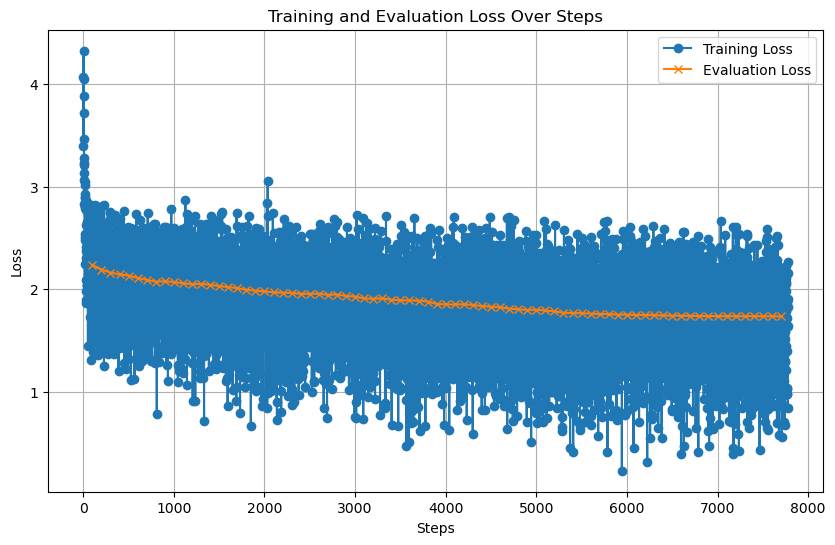

In [4]:
import json
import matplotlib.pyplot as plt

# read trainer.state.log_history from path
with open("./outputs/model_04222024_121416/trainer_state_log_history.json", "r") as file:
    trainer_log_history = json.load(file)

# plot trainer.state.log_history, plot training loss and evaluation loss
# Extracting training and eval loss data
train_losses = []
eval_losses = []
steps = []

for entry in trainer_log_history:
    if 'loss' in entry:
        train_losses.append((entry['step'], entry['loss']))
    if 'eval_loss' in entry:
        eval_losses.append((entry['step'], entry['eval_loss']))
    if 'train_loss' in entry:
        train_losses.append((entry['step'], entry['train_loss']))

# Sorting values by steps to align the data points correctly
train_losses.sort(key=lambda x: x[0])
eval_losses.sort(key=lambda x: x[0])

# Unzipping for plotting
train_steps, train_loss_values = zip(*train_losses)
eval_steps, eval_loss_values = zip(*eval_losses)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss_values, label='Training Loss', marker='o')
plt.plot(eval_steps, eval_loss_values, label='Evaluation Loss', marker='x')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Steps')
plt.legend()
plt.grid(True)
plt.show()

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [10]:
if True:
    max_seq_length = 4096 # 8192 | Choose any! We auto support RoPE Scaling internally!
    dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "outputs/model_04222024_121416/", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

input= "Below is the previous historical purchases and reviews of the user:\n```\nItem title: One Step Behind \n Item description: A dangerous man awakes in the care of a mysterious woman. Once the pieces of his past fall into place, he's faced with the stark choice of accepting his new found love or becoming the man he once was. \n rating: 4.0 \n review: Nice Hard Boiled Indie! Plenty of Bad Guys, Femme Fatales and one Big Bad Ass Reluctant Hero! If you like old school Film Noir -  more specifically Hard Boiled - you'll enjoy this little indie film. It reminded me a lot of the Coen Brother's BLOOD SIMPLE and another desert noir from the 90s starring Nick Cage RED ROCK WEST. It has that same pace and flavor to it and it pays of at the end. Well done!-------\nItem title: Untouched \n Item description: This legal drama explores the life-changing effects a secret abortion has on Mitch Thomas. A town startled by an infant found murdered in a dumpster, stirs Mitch, the reluctant attorney, conflicted by the love he lost, to unveil his haunting secret. \n rating: 4.0 \n review: Nice courtroom drama with it's heart in the right place. Beautifully shot and written, this is an intriguing story with a bittersweet ending. Really enjoyed it!-------\nItem title: The Man In The Silo \n Item description: A successful business man wakes up to find himself in a dilapidated grain silo, he must reconnect the dots of his traumatized memory to discover the truth of how he ended up there. \n rating: 5.0 \n review: This is a beautiful film full of great cinematic storytelling plus a classic re-hash of the Bernard Herman's Vertigo Score. Being a Hitchcock fan, I can honestly say that this is a true HITCHCOCKIAN film - which we hear a lot but hardly ever see. You can tell the film was made with so much attention to detail and passion by the great cinematography, transitions, acting, pace, acting and editing - and everything works together to achieve a great visual art piece. But don't get me wrong, it is also super exciting and entertaining as the film keeps you guessing from beginning to end. It is full of intrigue and suspense - and it is haunting. I highly recommend THE MAN IN THE SILO and I can almost guarantee you haven't seen anything like it!-------\n```\nAnd here is the user's intention: I really enjoy indie films with strong storytelling and emotional depth, so I'm looking for a movie that will steal my heart and make me want to fall in love all over again.\nPlease infer the user's preference based on historical purchases and reviews along with the user's intention, and then recommend an item for this user and provide its description."
inputs = tokenizer(
[
    "### Input:\n{inputs}\n\n### Response:{outputs}".format(inputs= input, outputs= ""),
], return_tensors = "pt").to("cuda")

# outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
# tokenizer.batch_decode(outputs)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
<bos>### Input:
Below is the previous historical purchases and reviews of the user:
```
Item title: One Step Behind 
 Item description: A dangerous man awakes in the care of a mysterious woman. Once the pieces of his past fall into place, he's faced with the stark choice of accepting his new found love or becoming the man he once was. 
 rating: 4.0 
 review: Nice Hard Boiled Indie! Plenty of Bad Guys, Femme Fatales and one Big Bad Ass Reluctant Hero! If you like old school Film Noir -  more specifically Hard Boiled - you'll enjoy this little indie film. It reminded me a lot of the Coen Brother's BLOOD SIMPLE and another desert noir from the 90s starring Nick Ca

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).